# Пример работы K-means

In [1]:
%matplotlib inline 
import k_means as km
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:

seed = 10
n_data = 200
n_clusters = 4
n_centers = 4
file = 'input.txt'

lines = km.GetLines(file) # или просто blobs[0]
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива

core_list = km.SetCores(file, number_of_clusters = n_clusters)
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

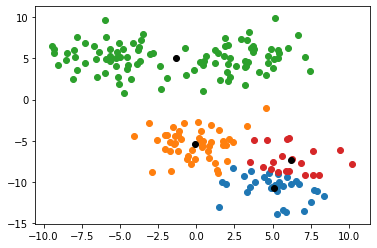

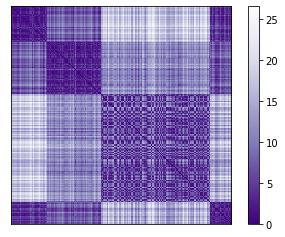

In [3]:
km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

Черными точками обозначены центры наших кластеров

В первом случае выбор центров кластеров происходит случайно. Если случится так, что центры совпадут, то логично считать их за центр одного и того же кластера. 

Видно, что такая стратегия инициализации работает достаточно хорошо.

Давайте попробуем уменьшить число кластеров:

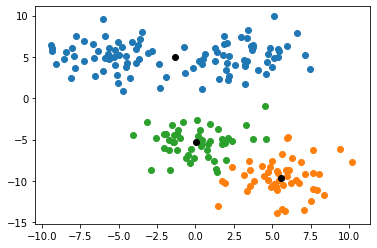

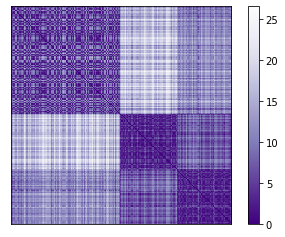

In [4]:
n_clusters = 3
core_list = km.SetCores(file, number_of_clusters = n_clusters)
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

У такого способа инициализации есть недостатки. Кластеризация в примере выше нас должна устроить, но может произойти и такое:

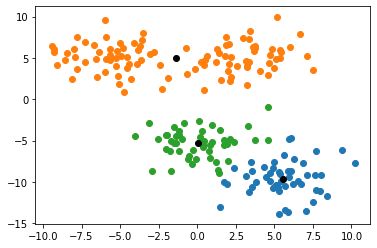

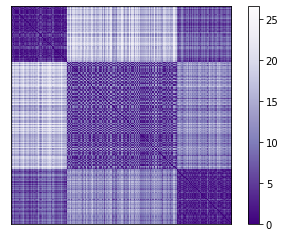

In [5]:
core_list = km.SetCores(file, number_of_clusters = n_clusters)
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

Последние два центра попали в нижнюю область, а первый - в верхнюю, но попарное расстояние между 2-м и 3-м кластером примерно равна попарному расстоянию в 1-м кластере. Видимо, это не совсем хорошо

# Что можно с этим сделать?

Вероятно, можно предложить более эффективный метод инициализации центров

Идея брать достаточно далекие (близкие) друг от друга вектора плоха по двум причинам:
1. При увеличении числа векторов, сложность максимизации (минимизации) расстояния между n точками будет O(n^n)
2. Расстояние между двумя точками в одном кластере может быть как большим, так и маленьким, относительно других кластеров.
Такой метод инициализации не решит нашей проблемы.

А что, если взять средний по всем векторам? Понятно, что он один, поэтому возьмем по всем без одного случайного:

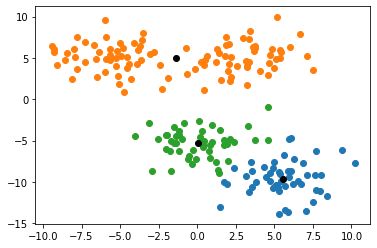

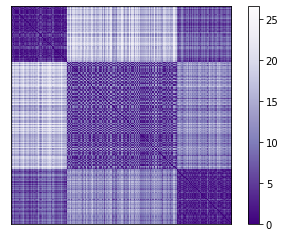

In [6]:
test_cores = []
for j in range(n_clusters):
    test_core = np.array(km.SetRandomLine(file_name = file))
    idx = np.where(lines == test_core)
    test_lines = np.delete(lines, idx)
    test_counter = 0
    test_core -= test_core
    for i, line in enumerate(test_lines):
        test_core += line
        test_counter += 1
    test_core /= (test_counter*1.0)
    test_cores.append(test_core)
    
test_cores = np.array(test_cores)

 
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

Видно, что проблему это не исправило, наоборот, теперь мы никогда не получаем удовлетворительный результат. 
Пробовать выбирать точки по краям я даже не стану, т.к. для каждой такой инициализации можно придумать пример, на котором она будет работать плохо.

Получается, что нам не выгодно инициализировать центры, исходя из положения их, относительно друг друга (первый способ). Также, инициализация, исходя из положения их относительно других векторов (второй) не дает нужного результа.

Отсюда можно сделать вывод, что случайная инициализация центров является самым оптимальным вариантом из тех, что я описал.

# Для каких задач подходит метод k-средних?

Из примеров выше видно, что результат не всегда схож с нашими предпочтениями, это не удивительно, ведь в качестве начальной инициализации центров мы используем случайные вектора.

Сам метод используется для кластеризации векторов по признаку их "евклидовой близости" (в качестве метрики выступает евклидова), возможно, если использовать другие метрики, то результат будет совсем другой.
Этот метод будет работать и в общем случае, когда нам нужно разделить объекты по n признакам. В этом случае, нам нужно выразить каждый признак в векторном виде и использовать n-мерное пространство.

Получается, что метод можно использовать для любых задач кластеризации, не требующих высокой точности вычислений.
Очевидным минусом метода k-средних является необходимость самому указывать число кластеров. Попробуем это исправить.


# Автоматический выбор числа кластеров

Я вижу два возможных пути решения этой задачи:
1. Априорный выбор числа кластеров
2. Пересчет количества кластеров, путем анализа модели с каким-то заданным числом кластеров

Чем плох способ №1? Мы ничего не знаем об объектах. Нам может попасться и один, и два и так далее кластеров. Единственным признаком кластеризации является плотность векторов, поэтому до вычисления точек этой самой плотности, мы ничего сказать не сможем. А вычисление точек плотности, по сути, и является кластеризацией. Поэтому в общем случае применим только второй путь.


Почему только в общем случае?- Вероятно, для конкретных задач можно подобрать эвристику выбора числа кластеров. Допустим, мы хотим разделить на условные группы овец, пасущихся на поле 100 x 100 . Нам известно, количество этих овец (50), также мы знаем, что козы стараются держаться в группах, размера не меньше 5-и и не больше 20-и особей. Соотвествтенно, мы можем сказать, что количество кластеров будет не больше 10-и и не меньше 3-х.  Более того, мы знаем размер поля, соответственно, знаем максимальное расстояние между двумя коровами, по этим данным можно предсказать число кластеров более точно.

Способ №2: 

Давайте попробуем первое, что придет в голову: 

Фиксируем кластер. Попробуем упорядочить наши вектора по норме, после чего посмотреть на график расстояний вектора и предыдущего к нему (для всех векторов в кластере). Мы предположили, что будем наблюдать большие "скачки" на графике, в случае, если вектора будут "улетать" слишком далеко от центра. Основываясь на этих данных, будем говорить, что этот кластер нужно разделить на два.


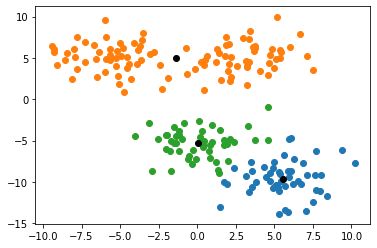

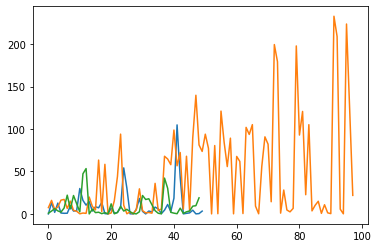

In [7]:
def ShowDistances(distance_core_array):
    for dist_core in distance_core_array:
        plt.plot(dist_core)
    plt.show()

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
distance_core_array = km.MakeDistanceCoreArray(core_list, cluster_list, lines)
average_distance_array = km.AverageDistance(distance_core_array)
ShowDistances(distance_core_array)

Действительно, у "плохого" кластера наблюдаются большие скачки попарных расстояний.

Попробуем изменить число кластеров и посмотрим, что будет

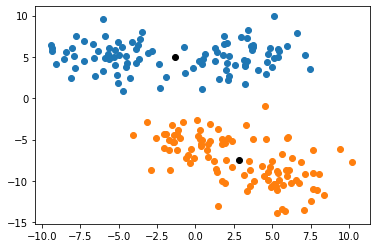

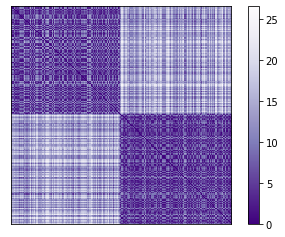

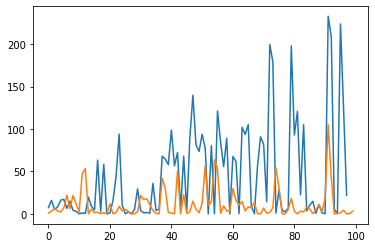

In [8]:
core_list = km.SetCores(file, number_of_clusters = 2)
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

distance_core_array = km.MakeDistanceCoreArray(core_list, cluster_list, lines)
average_distance_array = km.AverageDistance(distance_core_array)

ShowDistances(distance_core_array)

Можно видеть, что графики более-менее одинаковы, что означает, что из сравнения их друг с другом мы не получим никакой информации. 

Остается надежда сравнивать каждый кластер "сам с собой", то есть, при больших скачах (в нашем случае, например, 200) делить кластер на два. 
Минус данного подхода очевиден: в общем случае нам не известны размеры кластеров, а разделить полноценный кластер на 2 плохих мы не хотим

Минус этого метода не только в том, что мы не знаем размеры кластеров. Дело в том, что норма - не лучший способ отсортировать кластеры, лучше было бы выбрать какой-нибудь крайний вектор кластера и сортировать остальные относительно него. При этом такая модель будет обладать все теми же недостатками.

Отсюда заключаем, что, анализируя кластер, сказать, можно ли его разделить на два - очень трудно, будем искать другой способ.

Попытка #2: 

Нам трудно говорить что-то о фиксированном кластере, попробуем что-нибудь сказать о их паре:

Возьмем 2 кластера и посмотрим на n ближайших друг к другу вектора в каждом кластере. Будем говорить, что два кластера можно объединить в один, если среднее расстояние между этими 2n векторами меньше указанного нами порога. Предположим, что порог в рамках каждой задачи постоянен.


In [9]:
def AverageDistOfNearestVecs(nearest_pairs):
    aver_dist = 0
    count = 0
    for pair in nearest_pairs:
        aver_dist += km.EuclideDistance(pair[0], pair[1])
        count += 1
    aver_dist /= (count * 1.0)
    return aver_dist

In [10]:
def SetNearestVectors(from_core, to_core, core_list, cluster_list, lines, amount_of_vectors):
    for i, cluster in enumerate(cluster_list):
        from_indexes = np.argwhere(cluster_list == from_core)
        from_vectors = np.take(lines, np.reshape(from_indexes, np.size(from_indexes)), axis=0)
        
    for i, cluster in enumerate(cluster_list):
        to_indexes = np.argwhere(cluster_list == to_core)
        to_vectors = np.take(lines, np.reshape(to_indexes, np.size(to_indexes)), axis=0)
    if (np.size(from_vectors, axis=0) >= amount_of_vectors) and (np.size(to_vectors, axis=0) >= amount_of_vectors):
        pairs = np.zeros((amount_of_vectors, np.size(lines[0]), 2))
    else:
        pairs = np.zeros((min(np.size(from_vectors, axis=0), np.size(to_vectors, axis=0)), np.size(lines[0]), 2))
  
    for i in range(np.size(pairs, axis=0)):
        min_dist = km.EuclideDistance(from_vectors[0], to_vectors[0])
        nearest_vectors = np.array([from_vectors[0], to_vectors[0]])
        for to_vector in to_vectors:
            for from_vector in from_vectors:
                dist = km.EuclideDistance(from_vector, to_vector)
                if dist < min_dist:
                    min_dist = dist
                    nearest_vectors[0] = from_vector
                    nearest_vectors[1] = to_vector

        pairs[i] = nearest_vectors
        from_vectors = np.delete(from_vectors, from_vectors.tolist().index(nearest_vectors[0].tolist()), axis=0)
        to_vectors = np.delete(to_vectors, to_vectors.tolist().index(nearest_vectors[1].tolist()), axis=0)
    return pairs

In [11]:
def ClusterDownCorrect(core_list, lines, cluster_list, amount_of_vectors, optimal_average_distance):
    new_core_list = copy.deepcopy(core_list)
    new_cluster_list = copy.deepcopy(cluster_list)
    flag = False
    for i, core1 in enumerate(core_list[:-1]):
        for j, core2 in enumerate(core_list[i + 1:]):
            near_pairs = SetNearestVectors(from_core=i, to_core=j + i + 1, core_list=core_list,
                                           cluster_list=cluster_list, lines=lines, amount_of_vectors=amount_of_vectors)
            aver_dist = AverageDistOfNearestVecs(nearest_pairs=near_pairs)
            if aver_dist < optimal_average_distance:
                new_core_list = np.delete(new_core_list, new_core_list.tolist().index(core1.tolist()), axis=0)
                indexes = np.argwhere(new_cluster_list == i)
                indexes = np.reshape(indexes, np.size(indexes))
                new_cluster_list[indexes] = j + i + 1
                indexes = np.argwhere(new_cluster_list > i)
                indexes = np.reshape(indexes, np.size(indexes))
                new_cluster_list[indexes] -= 1
                # centers recounting
                new_core_list = np.zeros(shape=(len(new_core_list[:, 1]), 2), dtype=float)
                new_cluster_list_counter = np.zeros(shape=(len(new_core_list[:, 1])), dtype=int)
                for i, new_cluster in enumerate(new_cluster_list):
                    new_core_list[new_cluster_list[i]] += lines[i]
                    new_cluster_list_counter[new_cluster_list[i]] += 1
                for i, new_core in enumerate(new_core_list):
                    new_core_list[i] = new_core / (new_cluster_list_counter[i] * 1.0)
                new_core_list, new_cluster_list = ClusterDownCorrect(core_list=new_core_list, lines=lines,
                                                                     cluster_list=new_cluster_list,
                                                                     amount_of_vectors=amount_of_vectors,
                                                                     optimal_average_distance=optimal_average_distance)
                flag = True
                break
        if flag:
            break

    return new_core_list, new_cluster_list

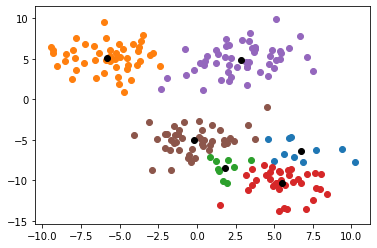

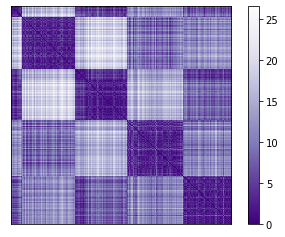

In [12]:
core_list = km.SetCores(file, number_of_clusters = 10)
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

core_list, cluster_list = ClusterDownCorrect(core_list, lines, cluster_list,
                                                amount_of_vectors = 10, optimal_average_distance = 6.5)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

Путем подбора коэффициента optimal_average_distance нам удалось добиться идеальной кластеризации для нашего примера.

Мы умеем уменьшать число кластеров до оптимального, но как нам увеличить это число?

Попробуем сделать так: разделим каждый кластер на 2, после чего уменьшим их число до оптимального функцией, которая у нас уже есть.

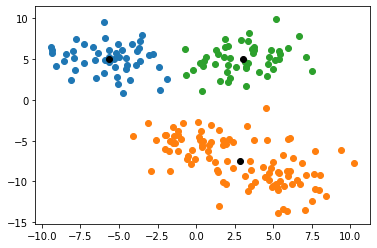

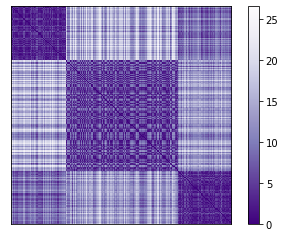

In [13]:

core_list = km.SetCores(file, number_of_clusters = 3)
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)

core_list, cluster_list = km.ClusterCorrect(core_list, lines, cluster_list,
                                                amount_of_vectors = 10, optimal_average_distance = 6.5)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

Как мы видим, работает очень даже ничего. 

Минус функции ClusterCorrect в том, что она не рекурсивная. То есть, её использование предполагает, что каждый кластер может быть разбит не более чем на два. Это очень ограничивает область её использования.

Стоит отметить, что её можно сделать рекурсивной, что позволит полностью исключить участие человека в выборе числа кластеров. (но это сложно, долго - я устал)

---------------------------------

Теперь у нас есть рабочий алгорим автоматического выбора числа кластеров - о чем еще можно мечтать?

# Визуализация матрицы попарных расстояний

Если вам зачем-то нужна красивая матрица попарных расстояний - эта глава для вас

Чтобы матрица выглядила более красиво, нам нужно как-то отсортировать наши кластеры по признаку их "близости" друг к другу. Для этого воспользуемся уже имеющимся методом выбора n векторов от каждого кластера и усреднения их попарного расстояния. Будем считать, что кластер A ближе к кластеру B, чем к С, если среднее значение попарных расстояний этих векторов между А и В меньше, чем между А и С

Сам алгоритм сортировки не такой уж и сложный:
1. Выбираем пару наиболее близких друг к другу кластеров и ставим их на первое и второе место
2. В цикле ищем третий (ближайший ко второму) кластер и т.д.

в результете получим сортировку кластеров по возрастанию между друг дружкой


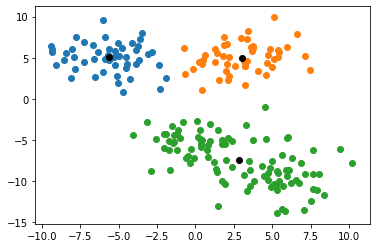

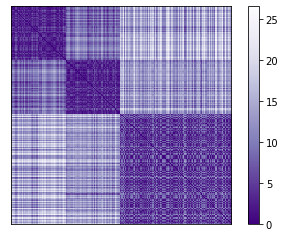

In [14]:
core_list, cluster_list = km.SortCores(core_list, cluster_list, lines, 10)

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
km.TakeDistanceTable(cluster_list = cluster_list, lines = lines, core_list = core_list)

#число n = 10 

Так-то лучше. 

# Оценим скорость работы метода k-средних

Сложность стандартного алгоритма k-средних можно оценить как O(n*c*i) , где c - число кластеров, i - количество итераций настройки центров.

Давайте посмотрим на время работы алгоритма при увеличении количества векторов

In [15]:
import time

file = 'test.txt'
km.VectorGenerator(file, 100)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 5)


In [16]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.036162614822387695 seconds ---


In [17]:
km.VectorGenerator(file, 1000)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 5)

In [18]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.35376787185668945 seconds ---


In [19]:
km.VectorGenerator(file, 10000)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 5)


In [20]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.076796054840088 seconds ---


Видим, что время выполнения уже на 5-и кластерах растет очень быстро. Это связано с большим увеличением числа итераций (i) при увеличении объема данных

Попробуем увеличить число кластеров вдвое:

In [21]:
km.VectorGenerator(file, 100)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 10)


In [22]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03919100761413574 seconds ---


In [23]:
km.VectorGenerator(file, 1000)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 10)


In [24]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.9462878704071045 seconds ---


In [25]:
km.VectorGenerator(file, 10000)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 10)


In [26]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 26.15495491027832 seconds ---


Видим, что при увеличении числа кластеров вдвое, время выполнения увеличивается, но не существенно

Попробуем увеличить число кластеров до 100:

In [27]:
km.VectorGenerator(file, 100)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 100)


--- 0.09588193893432617 seconds ---


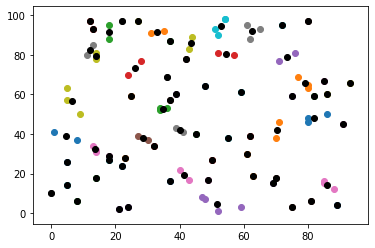

In [28]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))

km.TakePlot(core_list = core_list, cluster_list = cluster_list, lines = lines)
#мы не увидим 100 кластеров, т.к. алгоритм считает два одинаковых центра при начальной инициализации одним кластером

In [29]:
km.VectorGenerator(file, 1000)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 100)

In [30]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))


--- 3.684019088745117 seconds ---


In [31]:
km.VectorGenerator(file, 10000)
lines = km.GetLines(file)
cluster_list = np.zeros(shape=(len(lines[:,1])), dtype = int) #инициализация вспомогательного массива
core_list = km.SetCores(file, number_of_clusters = 100)

In [32]:
start_time = time.time()
core_list, cluster_list = km.Clustering(old_core_list = core_list, lines = lines, cluster_list = cluster_list)
print("--- %s seconds ---" % (time.time() - start_time))


--- 189.382737159729 seconds ---


Ой, что-то многовато. Не удивительно, ведь количество итераций растет как и с ростом количества векторов, так и с ростом числа кластеров.

Время работы также зависит от оптимальности написания кода, поэтому время работы программ других студентов может быть меньше.